In [2]:
import torch
import torch.nn as nn
from dataloaders import load_cifar10
from trainer import Trainer, compute_loss_and_accuracy
from task2 import create_plots, output_features

In [4]:
class ExampleModel(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # TODO: Implement this function (Task  2a)
        #Number of filters in conv layers
        num_filters1 = 32; num_filters2 = 64; num_filters3 = 128
        kernel_conv = 3; stride_conv = 1; padding_conv = 2
        kernel_pool = 2; stride_pool = 2
        
        
        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=num_filters1, kernel_size= kernel_conv,stride=stride_conv,padding=padding_conv),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=kernel_pool, stride = stride_pool),
            
            nn.Conv2d(in_channels=num_filters1,  out_channels=num_filters2, kernel_size=kernel_conv,stride=stride_conv,padding=padding_conv),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=kernel_pool, stride = stride_pool),
           
            nn.Conv2d(in_channels=num_filters2,   out_channels=num_filters3, kernel_size=kernel_conv,stride=stride_conv,padding=padding_conv),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=kernel_pool, stride = stride_pool))

        
        # The output of feature_extractor will be [batch_size, num_filters, 16, 16]
        #self.num_output_features = 32*32*32
        self.num_output_features = output_features(batch_size, num_filters1, num_filters2, num_filters3, kernel_conv, stride_conv, padding_conv,
          kernel_pool, stride_pool)
        linear_filter1 = 64

        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
            #nn.Linear(self.num_output_features, num_classes),
            nn.Linear(self.num_output_features, linear_filter1),
            nn.ReLU(),
            nn.Linear(linear_filter1, num_classes))
      

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        batch_size = x.shape[0]
        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)
        out = self.classifier(out)        
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out

In [5]:
import time
epochs = 10
batch_size = 64
learning_rate = 5e-2 # Should be 5e-5 for LeNet
early_stop_count = 4
dataloaders = load_cifar10('default', batch_size)
l2_reg_lambda = 0.0
model = ExampleModel(image_channels=3, num_classes=10)
trainer = Trainer(batch_size, learning_rate, early_stop_count, epochs, model, dataloaders, l2_reg_lambda)

start = time.time()
trainer.train()
final = time.time() - start
print("Seconds: ", final)

Files already downloaded and verified
Files already downloaded and verified


/cluster/home/vemunka/.conda/envs/tdt4265/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


ExampleModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Epoch: 0, Bps: 6.95, Global step:    351, 
 Train Loss: 1.74, Train Acc: 0.378, Val Loss: 1.74, Val Acc: 0.379, Test Loss: 1.73, Test Acc: 0.383
Epoch: 0, Bps: 7.76, Global step:    702, 
 Train Loss: 1.50, Train Acc: 0.465, Val Loss: 1.50, Val Acc: 

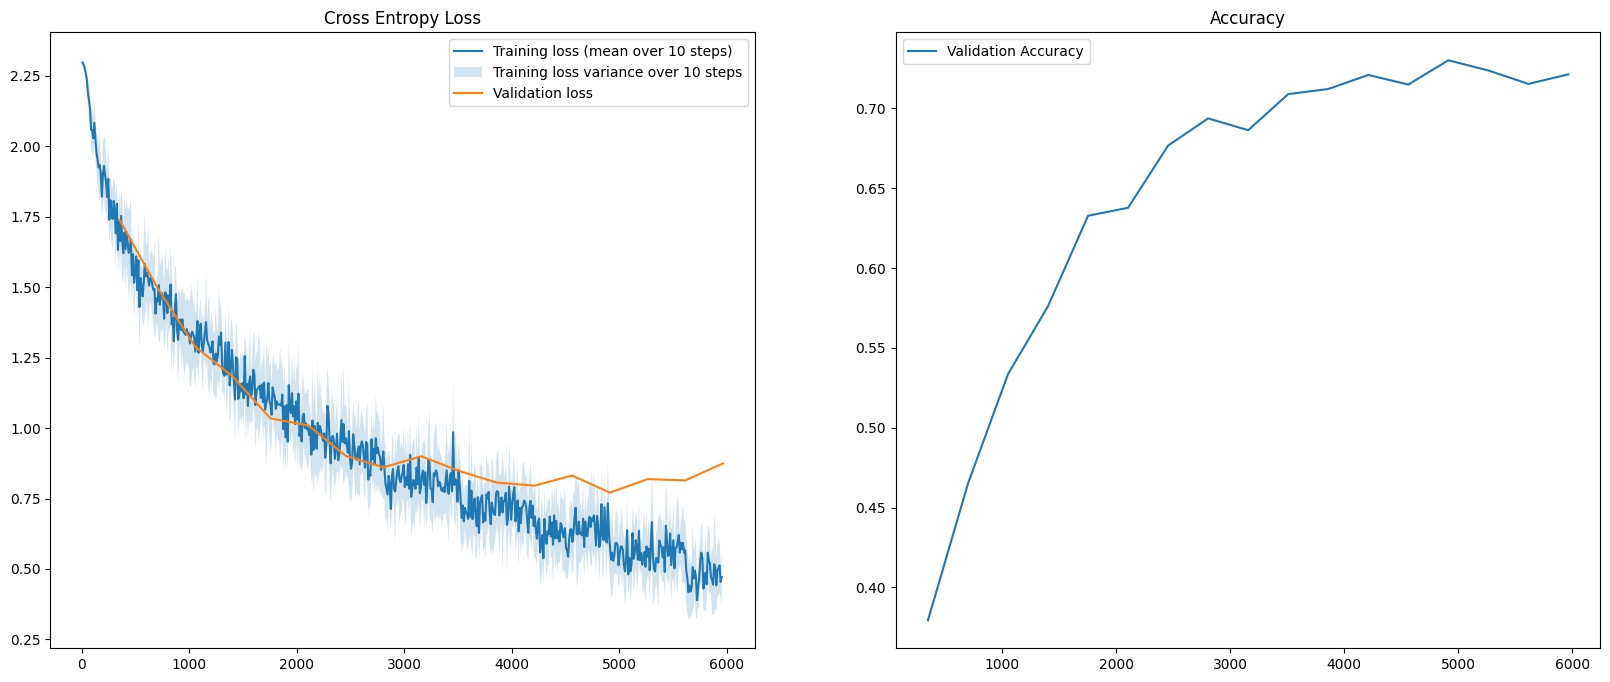

In [6]:
create_plots(trainer, "task2")